In [1]:
import sys
sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

np.random.seed(1234)
tf.set_random_seed(1234)


In [2]:

class ODE:
    def __init__(self,x,u,layers):
        self.lb=x.min(0)
        self.ub=x.max(0)
        self.x=x
        self.u=u
        self.layers=layers
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)        
        
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([0.0], dtype=tf.float32)
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True,gpu_options=gpu_options))
        self.x_tf=tf.placeholder(tf.float32,shape=[None,1]) 
        self.u_tf=tf.placeholder(tf.float32,shape=[None,1])  
        self.u_pred,self.f_u_pred=self.net_NS(self.x_tf)   
        self.loss=tf.reduce_sum(tf.square(self.u_tf-self.u_pred)+tf.reduce_sum(tf.square(self.f_u_pred)))   
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    def net_NS(self,x):
        lambda_1=self.lambda_1
        lambda_2=self.lambda_2
        u=self.neural_net(x, self.weights, self.biases)
        u_x=tf.gradients(u,x)[0]
        f=u_x-lambda_1*u+lambda_2*u*u
        return u,f

    def callback(self, loss, lambda_1, lambda_2):
        print('Loss: %.3e, l1: %.3f, l2: %.5f' % (loss, lambda_1, lambda_2))
    
    def train(self, nIter):
        tf_dict = {self.x_tf: self.x, self.u_tf: self.u}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)

            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = self.sess.run(self.lambda_2)
                print('It: %d, Loss: %.3e, l1: %.3f, l2: %.5f, Time: %.2f' % 
                      (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
                start_time = time.time()
                #plt.plot(self.x,self.predict(self.x),'*')
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.lambda_1, self.lambda_2],
                                loss_callback = self.callback)
    def predict(self, x_star):
        tf_dict = {self.x_tf: x_star}  
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star                   

It: 0, Loss: 4.331e+01, l1: 0.001, l2: -0.00100, Time: 0.31
It: 10, Loss: 3.334e+01, l1: 0.010, l2: -0.01033, Time: 0.26
It: 20, Loss: 2.449e+01, l1: 0.021, l2: -0.02102, Time: 0.04
It: 30, Loss: 1.658e+01, l1: 0.032, l2: -0.03139, Time: 0.04
It: 40, Loss: 1.182e+01, l1: 0.041, l2: -0.03647, Time: 0.04
It: 50, Loss: 1.022e+01, l1: 0.042, l2: -0.02616, Time: 0.04
It: 60, Loss: 9.593e+00, l1: 0.038, l2: -0.01251, Time: 0.04
It: 70, Loss: 9.388e+00, l1: 0.041, l2: -0.00440, Time: 0.04
It: 80, Loss: 9.032e+00, l1: 0.048, l2: -0.00028, Time: 0.04
It: 90, Loss: 8.730e+00, l1: 0.055, l2: 0.00496, Time: 0.04
It: 100, Loss: 8.444e+00, l1: 0.061, l2: 0.01214, Time: 0.04
It: 110, Loss: 8.161e+00, l1: 0.067, l2: 0.01938, Time: 0.04
It: 120, Loss: 7.883e+00, l1: 0.073, l2: 0.02620, Time: 0.04
It: 130, Loss: 7.613e+00, l1: 0.079, l2: 0.03308, Time: 0.04
It: 140, Loss: 7.348e+00, l1: 0.085, l2: 0.04008, Time: 0.04
It: 150, Loss: 7.091e+00, l1: 0.091, l2: 0.04700, Time: 0.04
It: 160, Loss: 6.841e+00, 

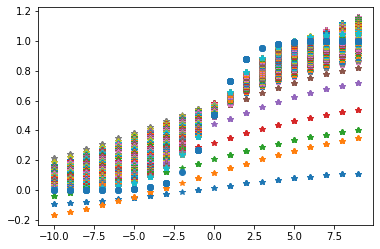

In [3]:
if __name__ == "__main__":
    x=np.random.randint(-10,10,size=50)
    y=tf.sigmoid(tf.cast(x,tf.float32))
    
    with tf.Session() as sess:
        y=y.eval()
    
    x=x[:,np.newaxis]
    y=y[:,np.newaxis]

    layers=[1,20,1]
    model=ODE(x,y,layers)
    model.train(2000)

    u_pred = model.predict(x)
    u=np.squeeze(u_pred)
    x=np.squeeze(x)
    plt.plot(x,u,'o')
    plt.show()
    lambda_1_value = model.sess.run(model.lambda_1)
    lambda_2_value = model.sess.run(model.lambda_2)
    